# Jet Classification with CNN

In this tutorial we are going to solve a classification problem.

This tutorial is partially based on [this tutorial](https://github.com/bmdillon/dlpp-tutorials/blob/main/tutorial-5-jet-classification-with-cnns.ipynb) and [these notes](https://arxiv.org/pdf/2211.01421.pdf) The data has been curated from the top tagging data from [2107.00656](https://arxiv.org/pdf/2107.00656.pdf).

You should already have this data prepared during the installation phase (tutorial 1!)

Note that in the original tutorial the files used were 1.5 GB (and around 20gb uncompressed) we have made them much smaller to facilitate running the tutorial. Furthermore, the original tutorial used `pytorch`, instead in this one we are using `tensorflow` to be consistent with the other tutorials (and the `nnpdf` codebase) however all concepts are equally applicable.

#### Description of the dataset

Top tagging dataset. Printout from `pd4ml.TopTagging.print_description()`.

    Description:
    14 TeV, hadronic tops for signal, QCD djets background, Delphes ATLAS detector card with Pythia. No MPI/pile-up included
    Particle-flow entries (produced by Delphes E-flow) have been clustered into anti-kT 0.8 jets in the pT range [550,650].
    All top jets are matched to a parton-level top within ∆R = 0.8, and to all top decay partons within 0.8. Also,|eta|_jet < 2 has been required.

    Ref:
    Deep-learned Top Tagging with a Lorentz Layer by A Butter, G Kasieczka, T and M Russell (arXiv: 1707.08966)

    Dataset shape:
    ~2M events have been stored divided between training (~1.6M) and test (~400k)) and the shape of the dataset is (# of events, 200, 4).
    The feature represent the leading 200 jet constituent four-momenta, with zero-padding for jets that have less than 200.
    Constituents are sorted by pT, with the highest pT one first.

    The second dataset that is included is just a flag "ttv" to identify what the event was before the reshaping operated by us. Here a legenda:
        0 = training event;
        1 = test event;
        2 = validation event;

    Note that in the current splitting of the dataset, training and validation events have been merged together as a unique training dataset. So for most intents and purposes one should just train the model on the first dataset and omit the second 'ttv' dataset altogether.

    The set label are 0 for QCD and 1 for top.
    
The 4-momenta is written as (E, px, py, pz)

Note:
It is possible to repeat this exercise by utilizing the bigger version of the dataset to really se the "power of the Big Data". For that please follow the instructions in the official [repository](https://github.com/erum-data-idt/pd4ml/blob/main/examples/1_top_plots.ipynb) of `pd4ml`. In the tutorial below we are using a smaller version of it with ~100k events instead of ~2M. we are going to use a small version of it. In our case, instead of having ~2M events we only have ~100k.

# Start of the tutorial

Let's begin by loading the top tagging data into the notebook

In [1]:
# First let's import everything we will need and set the folder where you put all your data!
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras

tf.keras.backend.clear_session()

plt.rcParams["figure.figsize"] = (10, 10)
data_folder = Path("data")
if not data_folder.exists():
    print("Warning! The data folder does not exist!")

In [2]:
# Load the data
dataset = np.load(data_folder / "toptagging.npz")
raw_input_data = dataset["x"] # (nevents, nconstituents, 4momenta)
labels = dataset["y"] # 0 for QCD, 1 for top

# Cut down the number of events, setting this to `False` could affect your computer memory!
if True:
    cutdown = int(4e4)
    raw_input_data = raw_input_data[:cutdown]
    labels = labels[:cutdown]

full_ndata = len(labels)
training_ndata = int(full_ndata/2)
# Take only part of the data for training, the rest will be "new unseen data"
raw_test_data = raw_input_data[training_ndata:]
test_labels = labels[training_ndata:]
# We will only go back to these test_arrays at the end
# from now on, we only see training data
ndata = training_ndata
raw_input_data = raw_input_data[:ndata]
labels = labels[:ndata]
print(f"We have loaded {ndata} events (and hidden {full_ndata-ndata} away to test our results later!)")

We have loaded 20000 events (and hidden 20000 away to test our results later!)


## Preprocessing jet images

We are going to treat this problem as an image classification problem.
To that end we are going to transform every jet event into an image.

We use the 4-momenta to compute $(p_{T}, \eta, \phi)$ (transverse momentum, pseudorapidity and azimuthal angle) for every constituent of the jet and then we use that information to cast them into a grid of pixels

The following cell contains auxiliary functions modified from [this notebook](https://github.com/bmdillon/dlpp-tutorials/blob/main/tutorial-5-jet-classification-with-cnns.ipynb)

In [3]:
epsilon = 1e-10
warning_shift_eta = 0
warning_shift_phi = 0

# Set the grid of 180 x 180 pixels
XPIXELS = np.arange(-2.6, 2.6, 0.029)
YPIXELS = np.arange(-np.pi, np.pi, 0.035)
NX = len(XPIXELS)
NY = len(YPIXELS)


def comp_eta(pt, pz):
    """Given the transverse and longitudinal momentum, return the pseudorapidity of the particle
    The input arrays are expected to be (n_events, n_constituents)
    """
    # Remove values that might introduce instabilities
    safe_vals = (np.abs(pt) > epsilon) & (np.abs(pz) > epsilon)
    theta = np.arctan(pt[safe_vals] / pz[safe_vals])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pt)
    etas[safe_vals] = np.log(np.tan(theta / 2))
    # Recover the very small not-zero ones
    etas[np.abs(pt) <= epsilon] = epsilon
    return etas


# Calculate the azimuthal angle of pixel entries
def comp_phi(px, py):
    """Compute the azimuthal angle in rad, np.arctan(0,0)=0 -> zero constituents set to -np.pi
    The input arrays are expected to be (n_events, n_constituents)
    """
    phis = np.arctan2(py, px)
    phis[phis < 0] += 2 * np.pi
    phis[phis > 2 * np.pi] -= 2 * np.pi
    phis = phis - np.pi
    return phis


def dot4m(p1s, p2s):
    """Compute the dot product between two arrays of 4-momenta, input_shape: (nevents, 4)"""
    vec = np.sum(p1s[:, 1:] * p2s[:, 1:], axis=-1)
    return p1s[:, 0] * p2s[:, 0] - vec


def invariant_mass(jets):
    """Compute the invariant mass of the jets. The input array is expected to be (n_events, n_constituent, 4)"""
    sum_momenta = np.sum(jets, axis=1)
    m2 = dot4m(sum_momenta, sum_momenta)
    return np.sqrt(np.maximum(0.0, m2))


def preprocessing_jet(x, y, w, warning_threshold=0.7, rotate=True, flip=True):
    """Preprocessing of the jets eta and phi (x and y) in preparation for the conversion into images.
    The weights (w) is the pt.
    The input of this function is 1dimensional arrays of n_constituents.
    It returns x and y shifted and rotated so that they are ripe to become the coordinate in an image.

    The image is rotated so that the principal axis
    is vertical.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment

    At the end of the function the image is flipped so that most weights
    lay in the (x<0, y>0)-plane
    """
    # Compute the centroid and shift x/y
    norm = w.sum(axis=-1)
    x_centroid = (x * w).sum(axis=-1) / norm
    y_centroid = (y * w).sum(axis=-1) / norm
    x = x - x_centroid[:, None]
    y = y - y_centroid[:, None]

    # The original notebook talks about possible problems
    # with the shifting, let's keep track of that just in case
    warning_shift_eta = np.count_nonzero(np.abs(x[:, 0]) > warning_threshold)
    warning_shift_phi = np.count_nonzero(np.abs(y[:, 0]) > warning_threshold)
    if warning_shift_eta != 0 or warning_shift_phi != 0:
        print(f"Problems in the shifts! {warning_shift_eta=}, {warning_shift_phi=}")

    if rotate:
        ### Compute rotation
        # Covariant matrix, eigenvectors corr. to principal axis
        u11 = (x * y * w).sum(axis=-1) / norm
        u20 = (x**2 * w).sum(axis=-1) / norm
        u02 = (y**2 * w).sum(axis=-1) / norm
        cov = np.array([[u20, u11], [u11, u02]]).T  # (nevents, 2, 2)

        evals, evecs = np.linalg.eig(cov)

        # Sort the eigenvalues
        sort_indices = np.argsort(evals, axis=-1)[::-1]
        ev_1 = []
        ev_2 = []
        for ev, ss in zip(evecs, sort_indices):
            ev_1.append(ev[..., ss[0]])  # Eigenvector with largest eigenvalue
            ev_2.append(ev[..., ss[1]])
        ev_1 = np.array(ev_1)
        ev_2 = np.array(ev_2)

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(ev_1[:, 0], ev_1[:, 1])

        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        stacked_xy = np.stack([x, y])
        transformed_mat = np.einsum("ijn, inc-> njc", rotation, stacked_xy)
        x_rot = transformed_mat[:, 0]
        y_rot = transformed_mat[:, 1]
    else:
        x_rot = x
        y_rot = y

    if flip:
        wxp = np.sum(x_rot > 0, axis=-1)
        wxm = np.sum(x_rot < 0, axis=-1)
        wyp = np.sum(x_rot > 0, axis=-1)
        wym = np.sum(x_rot < 0, axis=-1)

        # We want the X (eta) in the negative quadrant
        xflip = np.where(wxm > wxp, 1.0, -1.0)
        # And the y (phi) in the positive
        yflip = np.where(wym < wyp, 1.0, -1.0)

        x_rot *= xflip[:, None]
        y_rot *= yflip[:, None]

    return x_rot, y_rot


def pixelize(x, y, w):
    """Make the (x, y, w) arrays into pixels. To that end,
    discretize x and y by rounding (eta=1.3 -> pixel 1, eta=1.6->pixel2)

    The output is nevent images of (NX, NY) pixels
    """
    nevents = x.shape[0]
    nconsti = x.shape[1]
    z_out = np.zeros((nevents, NX, NY))
    ## Get the index in the pixel grid for x and y
    x_tmp = x[:, None, :] - XPIXELS[None, :, None]
    y_tmp = y[:, None, :] - YPIXELS[None, :, None]
    x_coord = np.argmin(np.abs(x_tmp), axis=1)
    y_coord = np.argmin(np.abs(y_tmp), axis=1)
    # Select only the constituents that are _inside_ the grid of pixels
    xmin = XPIXELS[0]
    xmax = XPIXELS[-1]
    ymin = YPIXELS[0]
    ymax = YPIXELS[-1]
    in_grid = (xmin <= x) & (x <= xmax) & (ymin <= y) & (y <= ymax)
    n_coord = np.repeat(np.arange(nevents)[:, None], nconsti, axis=1)
    z_out[n_coord[in_grid], x_coord[in_grid], y_coord[in_grid]] = w[in_grid]
    return z_out


# function to convert the jet to an image
def constituents_to_image(
    jets, n_constituents=50, rotate=True, flip=True, zoom_in=True, zoom_pixels=40
):
    """Transform the array of constituents of the jet into an image
    The input of this function is an array of (nevents, nconstituents, 4)
    The output is shape (nevents, NX*NY)
    where NX and NY is the number of pixels in the X and Y axis
    note that if the zoom is active they will be equal to zoom_pixels

    Parameters
    ----------
        jets: array of events (nevents, nconstituents, 4)
        n_constituents: int
            How many of the constituents should be used (default = 50)
        rotate: bool
            rotate the image so that the principal axis is in vertical
        flip: bool
            flip image so that they are in the (x<0, y>0)-plane
        zoom_in: bool
            zoom in to a smaller number of pixels around the center (default=true)
        zoom_pixels: int
            how many pixels around the center we actually want (default=40)
    """
    if n_constituents >= (nc := jets.shape[1]):
        raise ValueError(f"You asked to use {n_constituents} but only {nc} are available")

    jets = jets[:, :n_constituents, :]

    pxs = jets[:, :, 1]
    pys = jets[:, :, 2]
    pzs = jets[:, :, 3]

    print("Calculating pT...")
    weights = pts = np.sqrt(pxs**2 + pys**2)

    print("Calculating pseudorapidity... ")
    etas = comp_eta(pts, pzs)

    print("Calculating azimuthal angle")
    phis = comp_phi(pxs, pys)
    # This weird preshifting of phi is done here
    # because of the shifting done in the preprocessing
    phis = (phis.T - phis[:, 0]).T
    phis[phis < -np.pi] += 2 * np.pi
    phis[phis > np.pi] -= 2 * np.pi

    print("Preprocessing jets")
    x, y = preprocessing_jet(etas, phis, weights, rotate=rotate, flip=flip)

    print("Pixelixing")
    z_full = pixelize(x, y, weights)

    if not zoom_in:
        return z_full.reshape(-1, NX * NY)

    print(f"Cropping images to a {zoom_pixels}x{zoom_pixels} grid")

    # zoom in around the center (and normalize)
    # Prepare the crop-coordinates
    xcrop_m = int(NX / 2 - zoom_pixels / 2)
    xcrop_p = int(NX / 2 + zoom_pixels / 2)
    ycrop_m = int(NY / 2 - zoom_pixels / 2)
    ycrop_p = int(NY / 2 + zoom_pixels / 2)

    z_new = z_full[:, xcrop_m:xcrop_p, ycrop_m:ycrop_p]

    # Now normalize
    z_norm = np.sum(z_new, axis=(1, 2))[:, None, None]
    z_new /= z_norm + 1e-10
    return z_new.reshape(-1, zoom_pixels**2)

In [4]:
pixels = 40
print(f" Preparing the training set")
z_train = constituents_to_image(raw_input_data, zoom_pixels=pixels)
print("\n> Preparing the test set")
z_test = constituents_to_image(raw_test_data, zoom_pixels=pixels)

 Preparing the training set
Calculating pT...
Calculating pseudorapidity... 
Calculating azimuthal angle
Preprocessing jets
Pixelixing
Cropping images to a 40x40 grid

> Preparing the test set
Calculating pT...
Calculating pseudorapidity... 
Calculating azimuthal angle
Preprocessing jets
Pixelixing
Cropping images to a 40x40 grid


## Data visualization

Since we have images, before feeding them to the Machine Learning algorithms, let's play a bit with them to see how they look

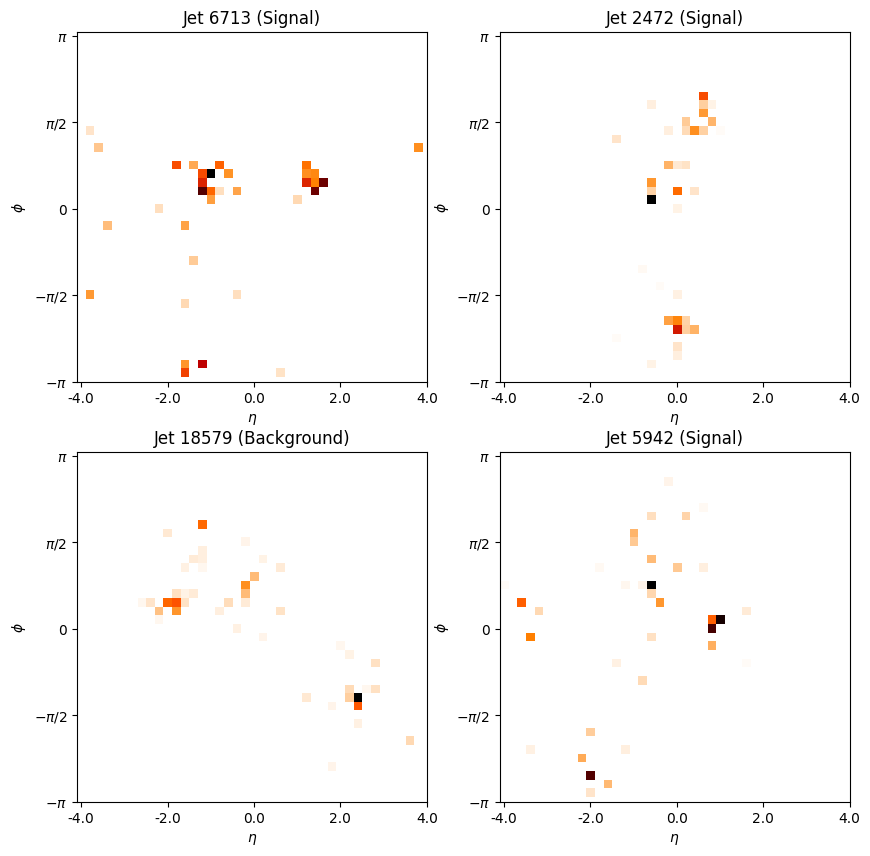

In [5]:
# Let's plot a few of these images we just constructed!
for i in range(4):
    plt.subplot(2, 2, i + 1)
    n = np.random.randint(ndata) # Take them randomly
    # Note that we need to reshape the array into a pixelsXpixels grid
    jet = z_train[n].reshape((pixels, pixels))
    if labels[n] == 1:
        label = "Signal"
    else:
        label = "Background"
    plt.title(f"Jet {n} ({label})")
    plt.imshow(jet, cmap="gist_heat_r")

    plt.xlabel(r"$\eta$")
    plt.ylabel(r"$\phi$")
    
    ticks = np.linspace(0, 40, 5)
    yti = [r"$\pi$", r"$\pi/2$", 0, r"$-\pi/2$", r"$-\pi$"]
    xti = [f"{i:.2}" for i in np.linspace(-4, 4, 5)]
    plt.yticks(ticks, yti)
    plt.xticks(ticks, xti)

We can get a "human learning" idea of what will be signal and what will be background by having a look at the average colormaps:

In [6]:
signal = z_train[ labels==1 ]
background = z_train[ labels==0 ]

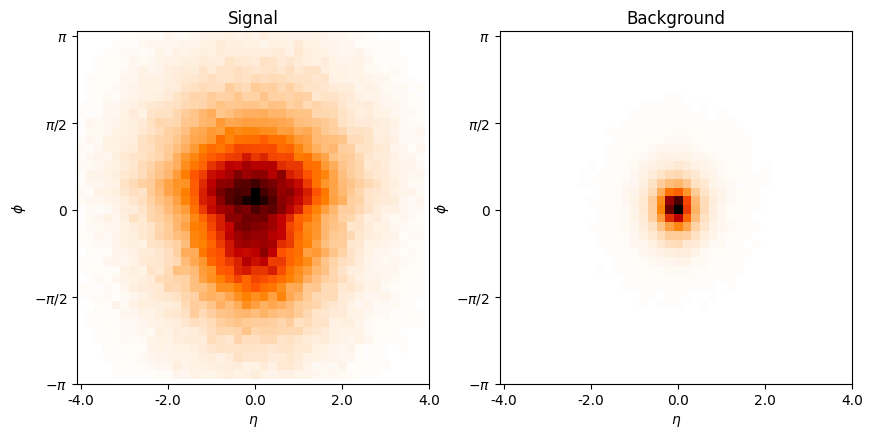

In [7]:
mean_signal = signal.mean(axis=0).reshape(pixels, pixels)
mean_bkg = background.mean(axis=0).reshape(pixels, pixels)

plt.subplot(1, 2, 1)
plt.title("Signal")
plt.imshow(mean_signal, cmap="gist_heat_r")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\phi$")

ticks = np.linspace(0, 40, 5)
yti = [r"$\pi$", r"$\pi/2$", 0, r"$-\pi/2$", r"$-\pi$"]
xti = [f"{i:.2}" for i in np.linspace(-4, 4, 5)]
plt.yticks(ticks, yti)
plt.xticks(ticks, xti)

plt.subplot(1, 2, 2)
plt.title("Background")
plt.imshow(mean_bkg, cmap="gist_heat_r")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\phi$")

ticks = np.linspace(0, 40, 5)
yti = [r"$\pi$", r"$\pi/2$", 0, r"$-\pi/2$", r"$-\pi$"]
xti = [f"{i:.2}" for i in np.linspace(-4, 4, 5)]
plt.yticks(ticks, yti)
plt.xticks(ticks, xti);

## Building the CNN

We first start by building a simple Convolutional Neural Network using TensorFlow's `sequential` model

In [8]:
# Put the values in a format suitable for tensorflow input and compute some parameters
# The tensorflow NN assumes color channels, in our case this (1)
in_data = z_train.reshape(-1, pixels, pixels, 1)
test_data = z_test.reshape(-1, pixels, pixels, 1)
# and set some parameters
epochs = 100
batch_size = 1000
trvl = 0.2 # % of data that go into validation

In [9]:
cnn_model = Sequential(name="CNN")
cnn_model.add(  keras.layers.Conv2D(4, (5,5), activation="relu", input_shape=in_data[0].shape, padding="same")  )
cnn_model.add(  keras.layers.MaxPooling2D((2,2))  )
cnn_model.add(  keras.layers.Activation("relu", name="relu"))
cnn_model.add(  keras.layers.Conv2D(1, (5,5), activation=None, padding="same")  )
cnn_model.add(  keras.layers.MaxPooling2D((2,2))  )
cnn_model.add(  keras.layers.Flatten() )
cnn_model.add(  keras.layers.Dense(50, activation="relu")  )
cnn_model.add(  keras.layers.Dense(1, activation="sigmoid")  )
cnn_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 4)         104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 4)        0         
 )                                                               
                                                                 
 relu (Activation)           (None, 20, 20, 4)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 1)         101       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 1)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 100)               0       

In [10]:
opt = keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(
    optimizer=opt, 
    loss=keras.losses.BinaryCrossentropy(),
)

In [11]:
# Let's prepare a checkpoint so that we have the best weights of every epoch
# this will allow us to play some interesting games
# Some more information about this https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
# Let's save the per-epoch weight:
output_path = "output_jets/output_path_epoch_{epoch:03d}.h5"
Path(output_path).parent.mkdir(exist_ok=True)

model_checkpoint = keras.callbacks.ModelCheckpoint(output_path, 
                                                   save_weights_only = True,
                                                   save_freq="epoch")

In [12]:
history = cnn_model.fit(
    in_data, 
    labels, 
    epochs=epochs, 
    batch_size=batch_size,
    callbacks=[model_checkpoint],
    validation_split=trvl
)

Epoch 1/100


2023-07-14 15:21:43.608819: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 2s 83ms/step - loss: 0.6869 - val_loss: 0.6805
Epoch 2/100
16/16 [==============================] - 1s 76ms/step - loss: 0.6710 - val_loss: 0.6568
Epoch 3/100
16/16 [==============================] - 1s 75ms/step - loss: 0.6348 - val_loss: 0.6025
Epoch 4/100
16/16 [==============================] - 1s 76ms/step - loss: 0.5609 - val_loss: 0.5095
Epoch 5/100
16/16 [==============================] - 1s 76ms/step - loss: 0.4685 - val_loss: 0.4333
Epoch 6/100
16/16 [==============================] - 1s 76ms/step - loss: 0.4193 - val_loss: 0.4148
Epoch 7/100
16/16 [==============================] - 1s 76ms/step - loss: 0.4096 - val_loss: 0.4087
Epoch 8/100
16/16 [==============================] - 1s 76ms/step - loss: 0.4044 - val_loss: 0.4083
Epoch 9/100
16/16 [==============================] - 1s 76ms/step - loss: 0.3966 - val_loss: 0.3939
Epoch 10/100
16/16 [==============================] - 1s 76ms/step - loss: 0.3908 - val_loss: 0.3888
Epoch 11/10

16/16 [==============================] - 1s 77ms/step - loss: 0.2748 - val_loss: 0.3095
Epoch 83/100
16/16 [==============================] - 1s 84ms/step - loss: 0.2756 - val_loss: 0.3070
Epoch 84/100
16/16 [==============================] - 1s 78ms/step - loss: 0.2741 - val_loss: 0.3063
Epoch 85/100
16/16 [==============================] - 1s 76ms/step - loss: 0.2716 - val_loss: 0.3060
Epoch 86/100
16/16 [==============================] - 1s 78ms/step - loss: 0.2706 - val_loss: 0.3078
Epoch 87/100
16/16 [==============================] - 1s 76ms/step - loss: 0.2716 - val_loss: 0.3065
Epoch 88/100
16/16 [==============================] - 1s 76ms/step - loss: 0.2702 - val_loss: 0.3079
Epoch 89/100
16/16 [==============================] - 1s 76ms/step - loss: 0.2694 - val_loss: 0.3051
Epoch 90/100
16/16 [==============================] - 1s 76ms/step - loss: 0.2677 - val_loss: 0.3048
Epoch 91/100
16/16 [==============================] - 1s 77ms/step - loss: 0.2680 - val_loss: 0.3053
Epo

## Evaluate and analyze the final results

Once the training is finished it is time to analyze our final results.
During the training the fitting function has given us some information about the training and validation losses.
Let us begin by plotting both curves (training and validation) as a function of the number of epochs.

In TensorFlow this information is provided in the `history` object which is the output of the `fit` method of the model.

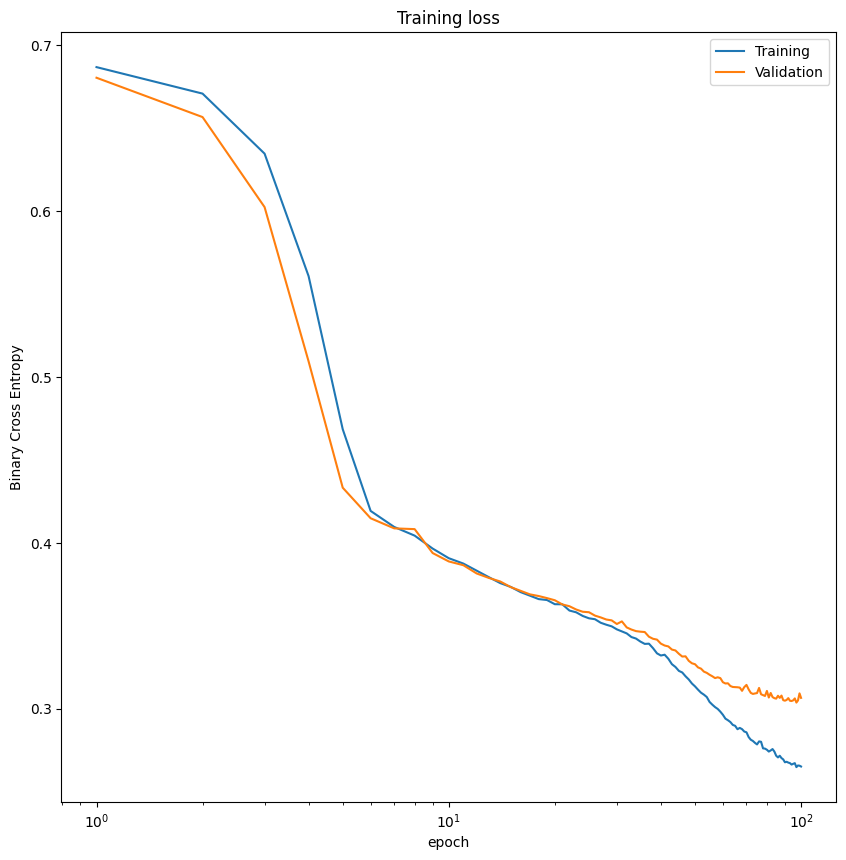

In [13]:
# Plot both the loss and the accuracy
plt.title("Training loss")
training = history.history["loss"]
validation= history.history[f"val_loss"]
xepoch = np.arange(1, len(training)+1)
plt.plot(xepoch, training, label="Training")
plt.plot(xepoch, validation, label="Validation")
plt.xlabel("epoch")
plt.ylabel("Binary Cross Entropy")
plt.legend();

# Let's use a log scale since the improvement in the first few epochs is always faster!
plt.xscale("log")

### Analyizing the results using the test data

At the beginning of the notebook we separated the input data into a training and test sets. We are now going to recover the test set to evaluate the accuracy of the model.

\begin{equation}
    \text{accuracy} = 100 \frac{\text{correct}}{\text{total}}
\end{equation}

Our model returns a probability for the input to truly be a top jet so we are going to plot a few curves.
We will start with a curve of the accuracy as a function of the threshold at which the events get catgorized as signal or background.

And then we will plot what are usually known as ROC [1] curves which are the True Positive Rate and False Positive Rate.

The true positive rate is often also called "signal efficiency" and it's defined as:
\begin{equation}
    \text{TPR} = \frac{\text{TP}}{\text{TP + FN}}
\end{equation}

While the rate of false positives is instead called background rejection:
\begin{equation}
    \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
\end{equation}

[1] receiver operating characteristic

In [14]:
def compute_accuracy(predictions_probability, labels, threshold=0.5):
    """Compute the accuracy of our model as:
        accuracy = correct / total * 100
    Where an event is selected as tagged if the probability given by the model is above threshold
    """
    predictions = np.where(predictions_probability >= threshold, 1, 0)[:, 0]
    correct = predictions == labels
    return 100 * np.count_nonzero(correct) / len(predictions)


def compute_roc(predictions_probability, labels, threshold=0.5):
    """Compute all quantities necessary for the roc curves
    returns, in this order:
        true_pos, true_neg, false_pos, false_neg
    """
    predictions = np.where(predictions_probability >= threshold, 1, 0)[:, 0]
    correct = predictions == labels
    positive = predictions == 1
    negative = predictions == 0
    true_pos = np.count_nonzero(correct & positive)
    true_neg = np.count_nonzero(correct & negative)
    false_pos = np.count_nonzero(positive) - true_pos
    false_neg = np.count_nonzero(negative) - true_neg
    return true_pos, true_neg, false_pos, false_neg


def true_positive_rate(predictions_probability, labels, threshold=0.5):
    """Compute the True Positive Rate"""
    tp, _, _, fn = compute_roc(predictions_probability, labels, threshold=threshold)
    return tp / (tp + fn)


def false_positive_rate(predictions_probability, labels, threshold=0.5):
    """Compute the False Positive Rate"""
    _, fp, tn, _ = compute_roc(predictions_probability, labels, threshold=threshold)
    return fp / (fp + tn)

625/625 [==============================] - 2s 2ms/step


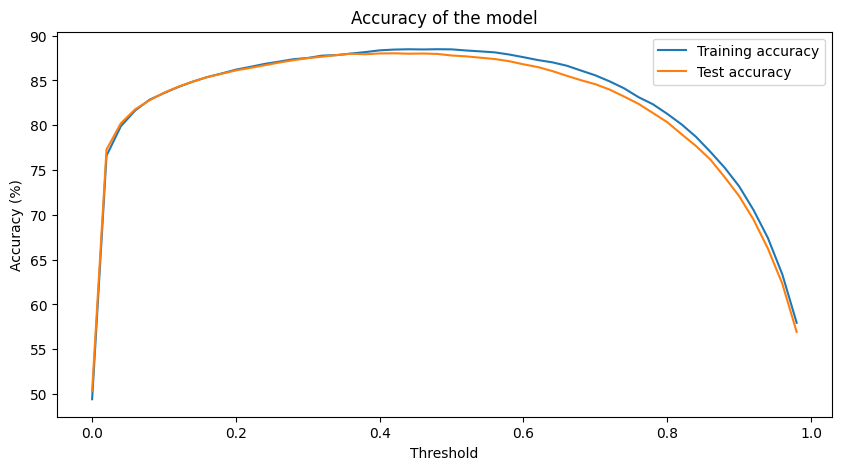

In [15]:
training_predictions = cnn_model.predict(in_data)
test_predictions = cnn_model.predict(test_data)
plt.rcParams["figure.figsize"] = (10, 5)

thresholds = np.arange(0, 1, 0.02)
training_acc = [compute_accuracy(training_predictions, labels, threshold=th) for th in thresholds]
test_acc = [compute_accuracy(test_predictions, test_labels, threshold=th) for th in thresholds]

plt.title("Accuracy of the model")
plt.plot(thresholds, training_acc, label="Training accuracy")
plt.plot(thresholds, test_acc, label="Test accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy (%)")
plt.legend()

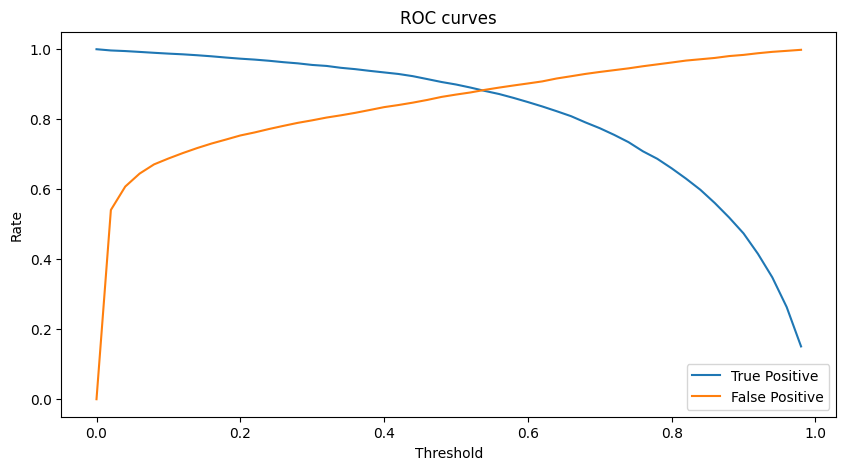

In [16]:
training_tpr = [true_positive_rate(training_predictions, labels, threshold=th) for th in thresholds]
training_fpr = [false_positive_rate(training_predictions, labels, threshold=th) for th in thresholds]
plt.title("ROC curves")
plt.plot(thresholds, training_tpr, label="True Positive")
plt.plot(thresholds, training_fpr, label="False Positive")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.legend();

In [17]:
# If you are not happy with the look of the plots above
# fear not! for the absolute best model has actually been saved!
# Uncomment the lines below and rerun the cells above!

# If you don't remember the filename that you put above, try running the following command
# !ls */*.h5

# Let's load the absolute best weights (from our point of view)
# cnn_model.load_weights("output_jets/output_path_epoch_023.h5")